In [1]:
from funtions import *

# Data

In [2]:
weekly_patterns_folder = '../data/weekly_patterns/'
naics_data_filepath = '../data/2-6 digit_2017_Codes.csv'
movement_data_folder = '../data/movement_data/'

# Weekly Pattern Files

The weekly pattern files obtained from [SafeGraph](https://www.safegraph.com/) contain data about the type and number of visits in Harris County, TX. A [kepler.gl](https://kepler.gl/demo/map?mapUrl=https://dl.dropboxusercontent.com/scl/fi/epe2tnmck483sqxsi8vf6/keplergl_43xg4c.json?rlkey=v515mn4vz4gcu7s04e24nlphj&dl=0) image is shown for visits to hospitals for one week.

<img src='../figures/visits.png' alt='Visits to hospitals in one week' width='500'/>

In [3]:
dates = get_dates(weekly_patterns_folder)
sample = pd.read_csv(weekly_patterns_folder + '/all_naics_2021-01-04.csv')

print('Dates: ', dates, '\nSample:')
sample.head()

Dates:  ['2021-01-04', '2021-01-11', '2021-01-18', '2021-01-25', '2021-02-01', '2021-02-08', '2021-02-15', '2021-02-22', '2021-03-01', '2021-03-08', '2021-03-15', '2021-03-22', '2021-04-05', '2021-04-12', '2021-04-19', '2021-04-26', '2021-05-03', '2021-05-10', '2021-05-17', '2021-05-24', '2021-05-31', '2021-06-07', '2021-06-14', '2021-06-21', '2021-06-28'] 
Sample:


,naics_code,poi_cbg,visitor_cbg,count
0,722515.0,482012507012,482012514011,6
1,722515.0,482012507012,482917011001,6
2,722515.0,482012507012,482012231001,5
3,722515.0,482012507012,482012409022,5
4,722515.0,482012507012,482012514022,5


# Spatial Preprocessing

Weekly pattern files are converted to a list dataframes (one dataframe per week). Not all visitor CBGs are from Harris County and need to be fitlered. Converting from CBG to CT requires aggregrating sums across CBGs within a CT.

<img src='../figures/fips.png' alt='Visits to hospitals in one week' width='500'/>

In [4]:
dfs = create_dfs(weekly_patterns_folder)
dfs_harris_county = filter_dfs(df_list=dfs, column='visitor_id', starts_with='48201')
dfs_harris_county[0].head()

,naics_code,poi_id,visitor_id,count
0,722515,482012507012,482012514011,6
2,722515,482012507012,482012231001,5
3,722515,482012507012,482012409022,5
4,722515,482012507012,482012514022,5
7,722515,482012507012,482012517002,4


In [5]:
dfs_tracts = convert_to_tracts(df_list=dfs_harris_county)
dfs_tracts[0].head()

,naics_code,poi_id,visitor_id,count
0,111421,554801,554801,4
1,111421,554801,555401,4
2,111421,554801,555502,4
3,221111,250301,250301,4
4,221111,250301,342002,4


# Movement-type Stratification

Descriptions of all NAICS codes can be downloaded from [https://www.census.gov/naics](https://www.census.gov/naics). 

<img src="../figures/maps.svg" alt="FIPS diagram" width="400"/>

In [6]:
naics_df = get_naics_df(naics_data_filepath, num_digits=3, starts_with='62')
naics_df

,Code,Name
1837,621,Ambulatory Health Care Services
1880,622,Hospitals
1890,623,Nursing and Residential Care Facilities
1906,624,Social Assistance


In [7]:
dfs_hospitals = filter_dfs(df_list=dfs_tracts, column='naics_code', starts_with='622')
dfs_hospitals[0].head()

,naics_code,poi_id,visitor_id,count
119453,622110,100000,100000,10
119454,622110,100000,221100,4
119455,622110,100000,222402,8
119456,622110,100000,232302,4
119457,622110,100000,232401,4


# Building Weighted Adjacency Matrices, $A^{(n)}(t)$

For a NAICS code, $n$, create a list of matrices for $t = 1, 2, \dots, T$. The default uses CTs with movement for at least one time $t$, but can be customized.

In [8]:
mats_hospitals = build_matrices(df_list=dfs_hospitals)
tracts_hospitals = get_tracts(df_list=dfs_hospitals)

print('Number of weeks: ', len(dates))
print('Number of matrices: ', len(mats_hospitals))
print('Number of CTs: ', len(tracts_hospitals))
print('Size of matrices: ', mats_hospitals[0].shape)

Number of weeks:  25
Number of matrices:  25
Number of CTs:  786
Size of matrices:  (786, 786)


In [9]:
tracts_filtered = tracts_hospitals[tracts_hospitals != '980000']
mats_hospitals_filtered = build_matrices(df_list=dfs_hospitals, tracts=tracts_filtered)

print('Size of filtered matrices:', mats_hospitals_filtered[0].shape)

Size of filtered matrices: (785, 785)


# Network Movements

We look at the network's total movements, in-degree, and out-degree for each time $t$.

In [10]:
total_movements = get_total_movements(mat_list=mats_hospitals_filtered)
in_degrees = get_degrees_in(mat_list=mats_hospitals_filtered)
out_degrees = get_degrees_out(mat_list=mats_hospitals_filtered)

print('Total movements shape (weeks):', total_movements.shape)
print('In-Degrees shape (weeks x CTs):', in_degrees.shape)
print('Out-Degrees shape (weeks x CTs):', out_degrees.shape)

Total movements shape (weeks): (25,)
In-Degrees shape (weeks x CTs): (25, 785)
Out-Degrees shape (weeks x CTs): (25, 785)


Text(0.5, 1.0, 'Out-Degrees')

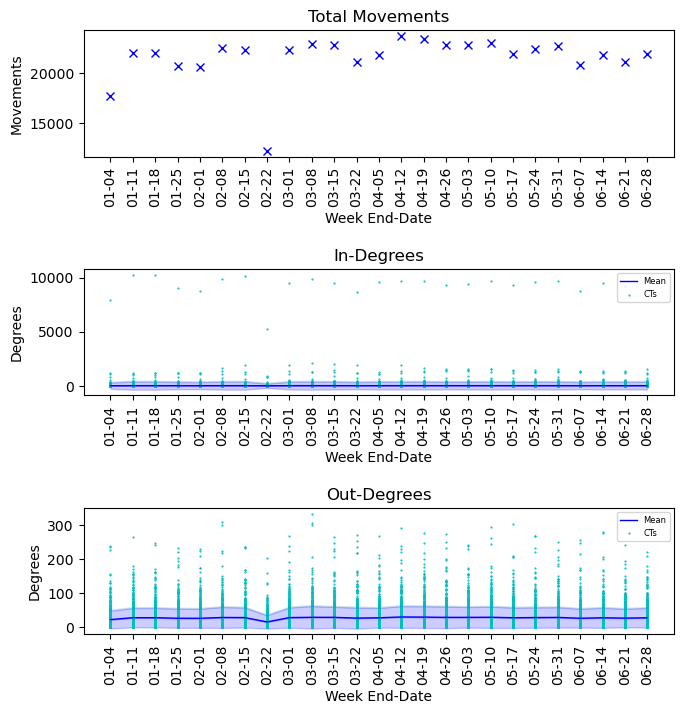

In [11]:
fig, ax = plt.subplots(3,1, figsize=(8,8))
fig.tight_layout(pad=6.0)

plot_total_movements(total_movements, dates, ax[0])
ax[0].set_title('Total Movements')

plot_degrees(in_degrees, dates, ax[1])
ax[1].set_title('In-Degrees')

plot_degrees(out_degrees, dates, ax[2])
ax[2].set_title('Out-Degrees')



# Generate and save movement data

To reduce computation time, movement data is stored as a dictionary in a $n$.pkl file, for NAICS code $n$. Keys are tracts, degrees_in, degrees_out, and total_movements.

In [12]:
generate_movement_data(weekly_patterns_folder, movement_data_folder, naics_code='622')

In [13]:
data = load_movement_data(movement_data_folder, naics_code='622')
data.keys()

dict_keys(['Tract', 'In-Degree', 'Out-Degree', 'Total Movements'])